In [ ]:
import pickle
with open('sample_dict.pkl', 'rb') as f:
    sample_dict = pickle.load(f)

In [3]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))
training_clips = sample_dict[0]
test_clips = sample_dict[1]
print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:17760
crackles:17520
wheezes:17520
both:17538

[Test set]
none:2211
crackles:2190
wheezes:2191
both:2193


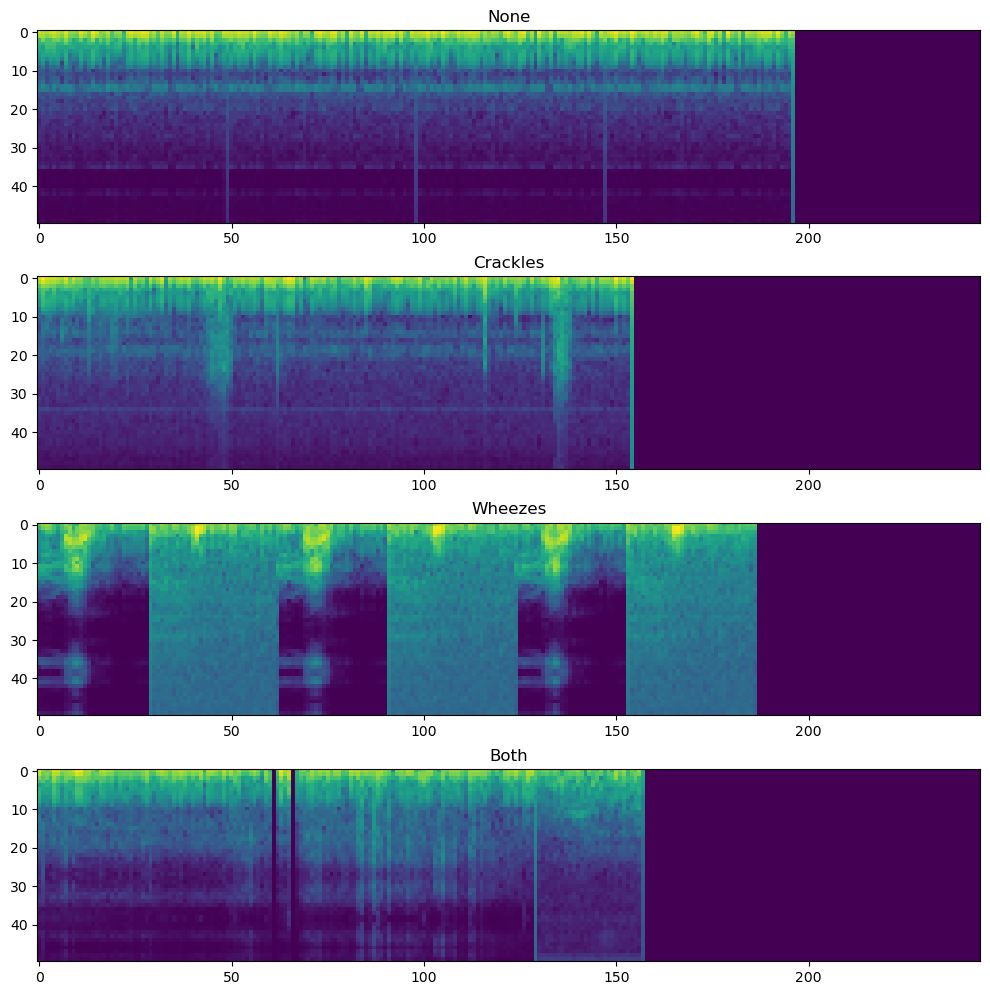

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
#Example of tiled sound samples
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 1
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

In [8]:
print(sample_height)
print(sample_width)

50
245


In [ ]:
#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

batch_size = 128
n_epochs =80

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten, LeakyReLU, GlobalAveragePooling2D, BatchNormalization, Multiply, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
from tensorflow.keras import mixed_precision
import os

clear_session()
mixed_precision.set_global_policy('mixed_float16')
log_dir = os.path.join("logs", "fit")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Enable profiling
tf.keras.backend.set_floatx('float32')
profiler_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=(1, 5))

# Define Attention Layers
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio=8):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(filters // ratio, activation='relu')
        self.dense2 = Dense(filters, activation='sigmoid')
    
    def call(self, x):
        avg_out = self.avg_pool(x)
        avg_out = self.dense1(avg_out)
        avg_out = self.dense2(avg_out)
        avg_out = Reshape((1, 1, self.filters))(avg_out)
        return Multiply()([x, avg_out])

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        return Multiply()([x, self.conv1(concat)])

# Build the model with attention layers
model = Sequential()
model.add(Conv2D(128, (7, 11), strides=(2, 2), padding='same', input_shape=(sample_height, sample_width, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))
model.add(ChannelAttention(128))
model.add(SpatialAttention())

model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))
model.add(ChannelAttention(256))
model.add(SpatialAttention())

model.add(Conv2D(256, (1, 1), padding='same'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))

model.add(Conv2D(512, (1, 1), padding='same'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (1, 1), padding='same'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile the model
opt = optimizers.Adam(learning_rate=0.00001, decay=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
stats = model.fit(
    train_gen.generate_keras(batch_size),
    steps_per_epoch=train_gen.n_available_samples() // batch_size,
    validation_data=test_gen.generate_keras(batch_size),
    validation_steps=test_gen.n_available_samples() // batch_size,
    epochs=n_epochs,
    callbacks=[lr_reducer, tensorboard_callback, profiler_callback]
)


c:\Users\91635\anaconda3\envs\audio_signal_processing_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\91635\anaconda3\envs\audio_signal_processing_env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\91635\anaconda3\envs\audio_signal_processing_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/80
  1/547 ━━━━━━━━━━━━━━━━━━━━ 52:04:27 343s/step - acc: 0.2734 - loss: 1.5136

Text(0.5, 1.0, 'Loss')

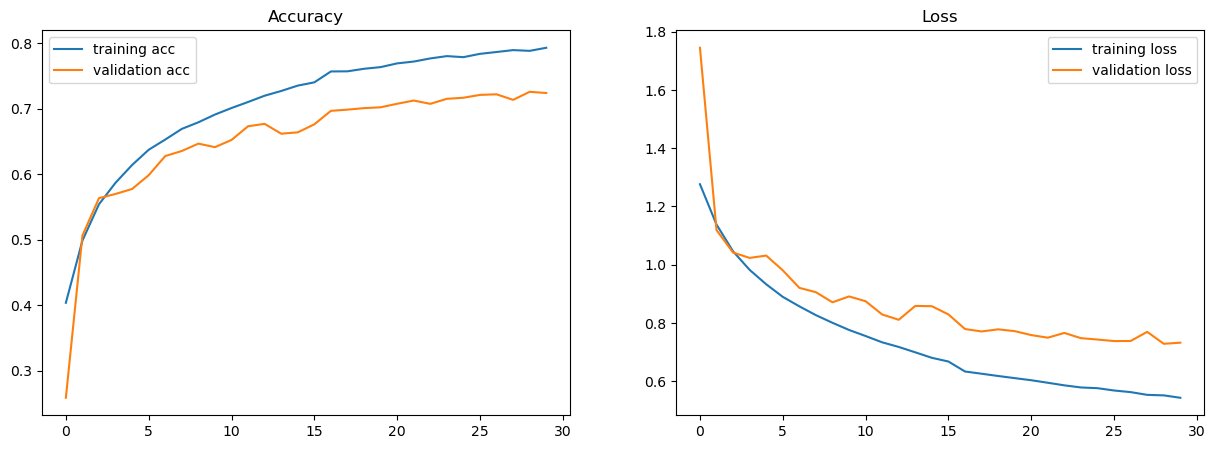

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
#print accuracy
print('Accuracy:{}'.format(np.sum(predictions == labels) / len(predictions)))

Accuracy:0.7277177006260671


In [ ]:
model.evaluate(test_set[0], test_set[1])

275/275 [==============================] - 19s 65ms/step - loss: 0.7332 - acc: 0.7277


[0.7331663370132446, 0.7277176976203918]

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / \
        cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    # colors will represent how 'correct' a class is, darker == better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           # create enough axis slots for each class
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           # axes will labeled with class names (if they exist) or ints
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)

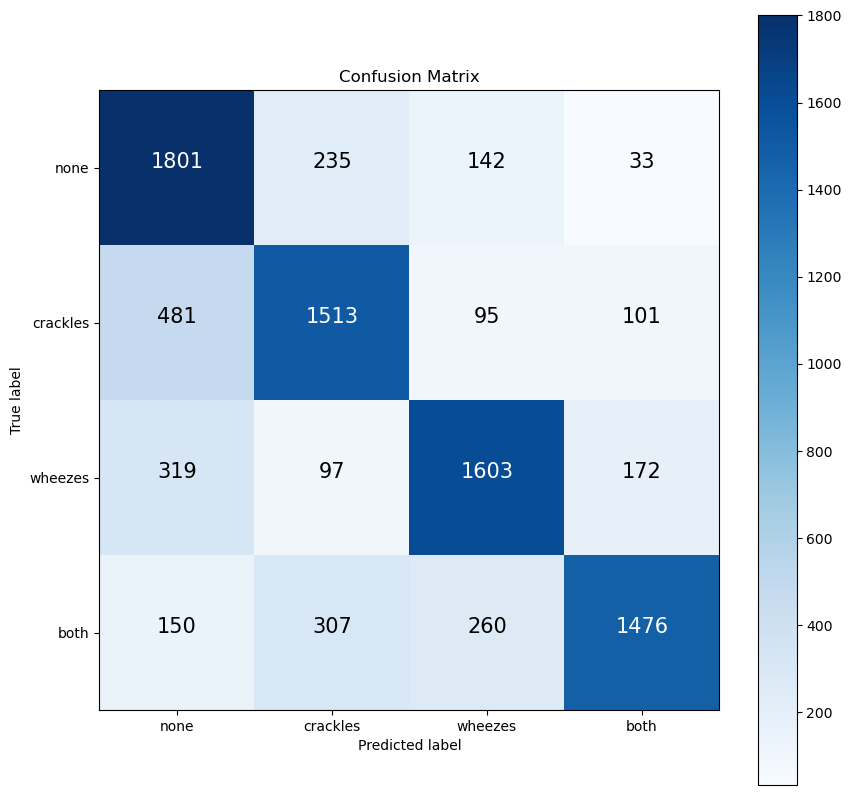

In [ ]:
import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import zipfile
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
make_confusion_matrix(labels, predictions, classes=['none','crackles','wheezes','both'], figsize=(10, 10), text_size=15, norm=False, savefig=False)

In [ ]:
#save model
model.save('model.h5')

In [ ]:
# Define a smaller batch size for evaluation to prevent memory issues
eval_batch_size = 32

# Calculate training accuracy
train_steps = train_gen.n_available_samples() // eval_batch_size
train_loss, train_accuracy = model.evaluate(
    train_gen.generate_keras(eval_batch_size),
    steps=train_steps,
    verbose=1
)

# Calculate test accuracy
test_steps = test_gen.n_available_samples() // eval_batch_size
test_loss, test_accuracy = model.evaluate(
    test_gen.generate_keras(eval_batch_size),
    steps=test_steps,
    verbose=1
)

# Print the final training and test accuracy
print(f'Final Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')

274/274 [==============================] - 21s 74ms/step - loss: 0.7356 - acc: 0.7270
Final Training Accuracy: 80.66%
Final Test Accuracy: 72.70%
